In [1]:
from BufferGeometry import BufferGeometry
from utils.analysis import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from scipy import linalg as la



/home/william/anaconda3/envs/python3_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
2025-05-21 12:36:25.585106: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 12:36:25.620229: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def extract_means(stats):
    return(np.mean(stats,axis = 0))

def extract_stds(stats):
    return(np.std(stats,axis = 0)/np.sqrt(stats.shape[0]))


In [3]:
# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()

with open("input_phrases.txt", "r") as f:
    phrases = [line.strip() for line in f.readlines() if line.strip()]

cosine_sim_stat = []
volumes_stat = []
gd_stat = []

for current_text in phrases:

    # Input text
    text = current_text
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs.input_ids

    # Forward pass with hidden states
    with torch.no_grad():
        outputs = model(input_ids, output_hidden_states=True, return_dict=True)

    hidden_states = outputs.hidden_states  # Tuple: [embedding] + [each layer output]

    #extract buffer states
    buffer_states = np.array([layer.squeeze(0).numpy() for layer in hidden_states])
    #loop for analysis

    volumes = []
    gd = []
    cos_sim = []
    mean_vector = []

    #reduce dimension of initial buffer
    buffer_scaled_0 = buffer_states[0,:,:] - np.mean(buffer_states[0,:,:], axis = 0, keepdims=True)
    U, S, Vt = la.svd(buffer_scaled_0)
    eigenvalues = S**2
    explained_variance_ratio = eigenvalues/np.sum(eigenvalues)
    n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9)

    U_reduced = U[:,:n_components]
    S_reduced = np.diag(S[:n_components])
    Vt_reduced = Vt[:n_components,:]

    buffer_reduced_0 = np.dot(np.dot(U_reduced,S_reduced),Vt_reduced)


    for i in range(buffer_states.shape[0]):
        bg = BufferGeometry(buffer_states[i,:,:])
        
        #volume
        volumes.append(bg.volume())
        #cosine similarity with last vector of the buffer
        cos_sim.append(bg.cosine_similarity(buffer_states[-1,:,:]))
        #mean vectors
        mean_vector.append(bg.mean_vector())

        #dimensionality reduction for Grassmann distance
        #SVD
        
        buffer_scaled = buffer_states[i,:,:] - np.mean(buffer_states[i,:,:], axis = 0, keepdims=True)
        U, S, Vt = la.svd(buffer_scaled)
        eigenvalues = S**2
        explained_variance_ratio = eigenvalues/np.sum(eigenvalues)
        n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9) + 1

        U_reduced = U[:,:n_components]
        S_reduced = np.diag(S[:n_components])
        Vt_reduced = Vt[:n_components,:]

        buffer_reduced = np.dot(np.dot(U_reduced,S_reduced),Vt_reduced)

        #compute grassman distance
        bg_reduced = BufferGeometry(buffer_reduced)
        gd.append(bg_reduced.grassmann_distance(buffer_reduced_0))
        
        #update buffer0
        #buffer_reduced_0 = buffer_reduced

    cosine_sim_stat.append(cos_sim)
    volumes_stat.append(volumes)
    gd_stat.append(gd)

cosine_sim_stat = np.array(cosine_sim_stat)
volumes_stat = np.array(volumes_stat)
gd_stat = np.array(gd_stat)




In [4]:
mean_cos = extract_means(cosine_sim_stat).flatten()
std_cos = extract_stds(cosine_sim_stat).flatten()

mean_gd = extract_means(gd_stat).flatten()
std_gd = extract_stds(gd_stat).flatten()

mean_volumes = extract_means(volumes_stat).flatten()
std_volumes = extract_stds(volumes_stat).flatten()

Text(0.5, 1.0, 'Cosine similarity')

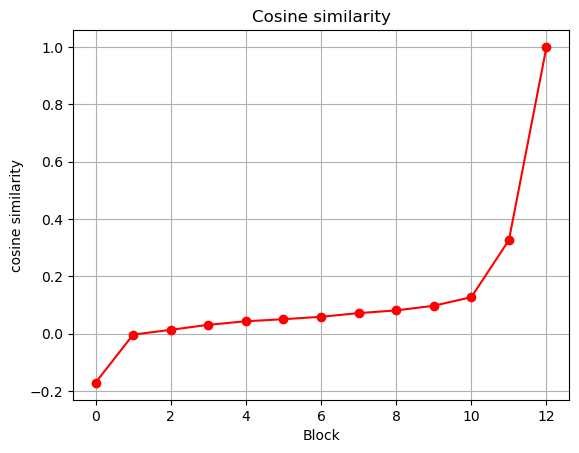

In [5]:
# --- Cosine Similarity Plot ---
plt.errorbar(range(len(mean_cos)),mean_cos,yerr = std_cos, fmt='-o', capsize = 2, color = 'red')
plt.grid()
plt.xlabel('Block')
plt.ylabel('cosine similarity')
plt.title("Cosine similarity")


Text(0.5, 1.0, 'Volume')

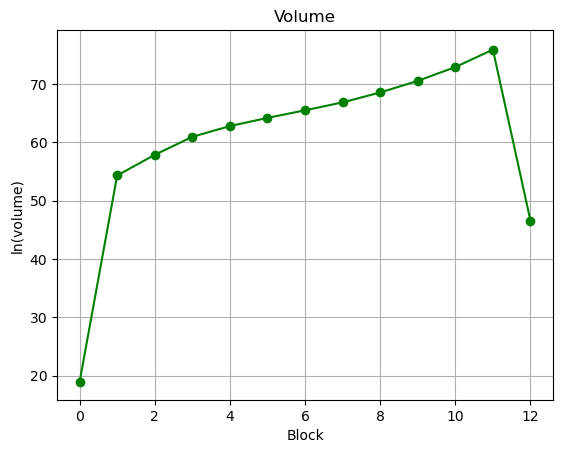

In [6]:
plt.errorbar(range(len(mean_volumes)), mean_volumes, yerr = std_volumes, fmt='-o',capsize = 2, color = 'green')
plt.grid()
plt.xlabel('Block')
plt.ylabel('ln(volume)')
plt.title("Volume")

Text(0.5, 1.0, 'Grassmann Distance  (w.r.t. the beginning)')

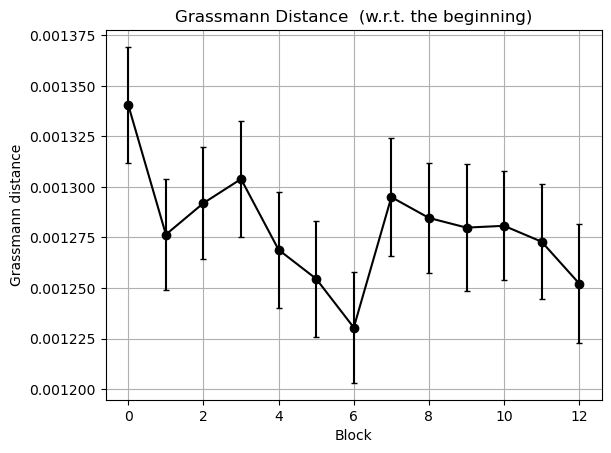

In [9]:
plt.errorbar(range(len(mean_gd)), mean_gd, yerr = std_gd, capsize = 2, fmt='-o', color = 'black')
plt.grid()
plt.xlabel('Block')
plt.ylabel('Grassmann distance')
plt.title("Grassmann Distance  (w.r.t. the beginning)")